In [1]:
import pytest
import numpy as np
import pandas as pd
import pandas_datareader as pdr

from cers import cers


In [2]:
# 2) run a single simulation and do a test
# 3) do multiple sims ... test you get same indiv sims
# 4) do monte carlo

# 5) certainty_equivalent
# 6) certainty_equivalent with mortality

# class simulator

# takes n x m dataframe of returns
# takes k x m+2 dataframe of weights, fixed pct, variable pct
# monte carlo=True/False in range(n), sample n without replacement
# replacement = true/false

# simulate 
#   actual_year= value in range(n-k+1)
    
# simulate_many
#   startyear
#   nyears
#   returns list of nyears dataframes n x m with the cash flows
    
# simulate_many_mc
#   n_trials
#   returns list of n_trials dataframes n x m with the cash flows
  
# certainty_equivalent(k_list)
#   - first each cash flow stream
#   - then over all streams, equal-weighted

# certainty_equivalent_mortality(k_list, mortality_table)
# calculate probability of being alive in years 1...k
# so now you have k lists with associated probabilities
#    certainty_adjust cash flow streams
#    not just full cash flow but range(nyears) cash flows 
#    then certainty adjust over the probability distribution of each sequence of cash flows
    

In [3]:
# load spreadsheet from Damodaran website into pandas dataframe
# data_xls = 'http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
# data_sheet = "Returns by year"
# # these will change as rows get added on Damodaran website
# skiprows = range(17)
# skipfooter = 10
# download_df = pd.read_excel(data_xls, 
#                          sheet_name=data_sheet, 
#                          skiprows=skiprows,
#                          skipfooter=skipfooter)
# download_df = download_df.set_index('Year')
# download_df.to_pickle('histretSP.pickle')

# load from pickle
RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 2, 12]]
return_df.columns=['stocks', 'tbonds', 'cpi']
return_df


,stocks,tbonds,cpi
Year,,,
1928,0.438112,0.008355,-0.011522
1929,-0.082979,0.042038,0.000000
1930,-0.251236,0.045409,-0.026712
1931,-0.438375,-0.025589,-0.089321
1932,-0.086424,0.087903,-0.103014
...,...,...,...
2016,0.117731,0.006906,0.012616
2017,0.216055,0.028017,0.021301
2018,-0.042269,-0.000167,0.024426


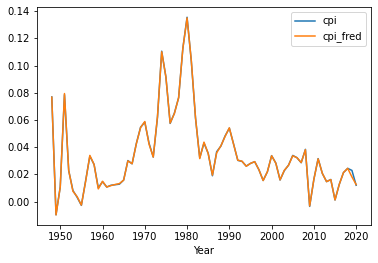

In [4]:
# damodaran sheet apparently has average cpi over the year

series = ['CPIAUCSL']

cpi_download = pdr.data.DataReader(series, 
                                   'fred', 
                                   start='1947-01-01')

cpi_download = cpi_download.reset_index()
cpi_download = cpi_download.resample('A', on='DATE').mean().reset_index()
cpi_download = cpi_download.set_index(pd.DatetimeIndex(cpi_download['DATE']).year)

cpi_test = return_df[['cpi']].copy()
cpi_test['cpi_fred'] = cpi_download['CPIAUCSL'].pct_change()
cpi_test = cpi_test.dropna()
cpi_test.plot();

<AxesSubplot:xlabel='Year'>

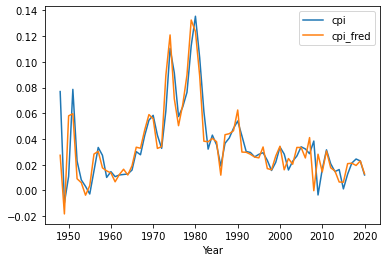

In [5]:
# we will use year-ending (resample to last)

series = ['CPIAUCSL']

cpi_download = pdr.data.DataReader(series, 
                                   'fred', 
                                   start='1947-01-01')

cpi_download = cpi_download.reset_index()
cpi_download = cpi_download.resample('A', on='DATE').last()
cpi_download = cpi_download.set_index(pd.DatetimeIndex(cpi_download['DATE']).year)

cpi_test = return_df[['cpi']].copy()
cpi_test['cpi_fred'] = cpi_download['CPIAUCSL'].pct_change()
cpi_test = cpi_test.dropna()
cpi_test.plot()

In [6]:
# should adjust 1928-1947 also but leave it for now
real_return_df = return_df.copy()
real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['tbonds'] = (1 + real_return_df['tbonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df

,stocks,tbonds
Year,,
1928,0.454874,0.020108
1929,-0.082979,0.042038
1930,-0.230686,0.074101
1931,-0.383290,0.069984
1932,0.018495,0.212842
...,...,...
2016,0.094931,-0.013634
2017,0.190860,0.006718
2018,-0.060487,-0.019186


In [7]:
# zero returns, zero spending (just check shape)
zero_df = real_return_df.copy()
zero_df['stocks'] = 0
zero_df['tbonds'] = 0

s = cers.Simulator(zero_df, 30,)
z = s.simulate_trial(1928, [0.5, 0.5], 0.00, 0.00)
assert(z.index[0]) == 1928, "start year == 1928"
assert(z.index[-1]) == 1957, "end year == 1957"
assert len(z) == 30, "length == 30"

z


,stocks,tbonds,perf,w_0,w_1,fixed,variable,variable_1m,perf_1p,starting,spend,ending
Year,,,,,,,,,,,,
1928,0,0,0.0,0.5,0.5,0.0,0.0,1.0,1.0,100.0,0.0,100.0
1929,0,0,0.0,0.5,0.5,0.0,0.0,1.0,1.0,100.0,0.0,100.0
1930,0,0,0.0,0.5,0.5,0.0,0.0,1.0,1.0,100.0,0.0,100.0
1931,0,0,0.0,0.5,0.5,0.0,0.0,1.0,1.0,100.0,0.0,100.0
1932,0,0,0.0,0.5,0.5,0.0,0.0,1.0,1.0,100.0,0.0,100.0
1933,0,0,0.0,0.5,0.5,0.0,0.0,1.0,1.0,100.0,0.0,100.0
1934,0,0,0.0,0.5,0.5,0.0,0.0,1.0,1.0,100.0,0.0,100.0
1935,0,0,0.0,0.5,0.5,0.0,0.0,1.0,1.0,100.0,0.0,100.0
1936,0,0,0.0,0.5,0.5,0.0,0.0,1.0,1.0,100.0,0.0,100.0


In [8]:
# zero returns, spend 2% per year, check ending value declines to 0.98 ** 30
return_df = download_df.iloc[:, [0, 2]]
return_df.columns = ['stocks', 'tbonds']
zero_df = return_df.copy()
zero_df['stocks'] = 0
zero_df['tbonds'] = 0
s = cers.Simulator(zero_df, 30, )
z = s.simulate_trial(1928, [0.5, 0.5], 0.0, 0.02)
assert(z['starting'].iloc[0]) == 100, "start port value == 100"
assert(z['ending'].iloc[-1]) == 100 * (0.98 ** 30), "end port value correct"
z

,stocks,tbonds,perf,w_0,w_1,fixed,variable,variable_1m,perf_1p,starting,spend,ending
Year,,,,,,,,,,,,
1928,0,0,0.0,0.5,0.5,0.0,0.02,0.98,1.0,100.000000,2.000000,98.000000
1929,0,0,0.0,0.5,0.5,0.0,0.02,0.98,1.0,98.000000,1.960000,96.040000
1930,0,0,0.0,0.5,0.5,0.0,0.02,0.98,1.0,96.040000,1.920800,94.119200
1931,0,0,0.0,0.5,0.5,0.0,0.02,0.98,1.0,94.119200,1.882384,92.236816
1932,0,0,0.0,0.5,0.5,0.0,0.02,0.98,1.0,92.236816,1.844736,90.392080
1933,0,0,0.0,0.5,0.5,0.0,0.02,0.98,1.0,90.392080,1.807842,88.584238
1934,0,0,0.0,0.5,0.5,0.0,0.02,0.98,1.0,88.584238,1.771685,86.812553
1935,0,0,0.0,0.5,0.5,0.0,0.02,0.98,1.0,86.812553,1.736251,85.076302
1936,0,0,0.0,0.5,0.5,0.0,0.02,0.98,1.0,85.076302,1.701526,83.374776


In [9]:
# 4% real return, spend fixed 4% of starting, assert ending value unchanged
RETURN = 0.04
FIXED = 0.04
NYEARS = 30
return_df = download_df.iloc[:, [0, 2]]
return_df.columns = ['stocks', 'tbonds']
zero_df = return_df.copy()
zero_df['stocks'] = RETURN
zero_df['tbonds'] = RETURN
s = cers.Simulator(zero_df, NYEARS, )
z = s.simulate_trial(1928, [0.5, 0.5], FIXED, 0)
assert(z['starting'].iloc[0]) == 100, "start port value == 100"
assert(z['ending'].iloc[-1]) == 100, "end port value correct"
z


,stocks,tbonds,perf,w_0,w_1,fixed,variable,variable_1m,perf_1p,starting,spend,ending
Year,,,,,,,,,,,,
1928,0.04,0.04,0.04,0.5,0.5,4.0,0,1,1.04,100.0,4.0,100.0
1929,0.04,0.04,0.04,0.5,0.5,4.0,0,1,1.04,100.0,4.0,100.0
1930,0.04,0.04,0.04,0.5,0.5,4.0,0,1,1.04,100.0,4.0,100.0
1931,0.04,0.04,0.04,0.5,0.5,4.0,0,1,1.04,100.0,4.0,100.0
1932,0.04,0.04,0.04,0.5,0.5,4.0,0,1,1.04,100.0,4.0,100.0
1933,0.04,0.04,0.04,0.5,0.5,4.0,0,1,1.04,100.0,4.0,100.0
1934,0.04,0.04,0.04,0.5,0.5,4.0,0,1,1.04,100.0,4.0,100.0
1935,0.04,0.04,0.04,0.5,0.5,4.0,0,1,1.04,100.0,4.0,100.0
1936,0.04,0.04,0.04,0.5,0.5,4.0,0,1,1.04,100.0,4.0,100.0


In [10]:
# return 0.02% variable spending 0.02/1.02, check final value unchanged
RETURN = 0.02
VARSPEND = 0.02/1.02
NYEARS = 30
return_df = download_df.iloc[:, [0, 2]]
return_df.columns = ['stocks', 'tbonds']
zero_df = return_df.copy()
zero_df['stocks'] = RETURN
zero_df['tbonds'] = RETURN
s = cers.Simulator(zero_df, NYEARS, )
z = s.simulate_trial(1928, [0.5, 0.5], 0, VARSPEND)
assert (z['starting'].iloc[0]) == 100, "start port value == 100"
assert (z['ending'].iloc[-1]) == 100, "end port value correct"
z


,stocks,tbonds,perf,w_0,w_1,fixed,variable,variable_1m,perf_1p,starting,spend,ending
Year,,,,,,,,,,,,
1928,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1929,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1930,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1931,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1932,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1933,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1934,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1935,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1936,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0


In [11]:
# return 0.02% variable spending 0.02/1.02, check final value unchanged
RETURN = 0.02
VARSPEND = 0.02/1.02
NYEARS = 30
return_df = download_df.iloc[:, [0, 2]]
return_df.columns = ['stocks', 'tbonds']
zero_df = return_df.copy()
zero_df['stocks'] = RETURN
zero_df['tbonds'] = RETURN
s = cers.Simulator(zero_df, NYEARS, )
z = s.simulate_trial(1928, [0.5, 0.5], 0, VARSPEND)
assert (z['starting'].iloc[0]) == 100, "start port value == 100"
assert (z['ending'].iloc[-1]) == 100, "end port value correct"
z

,stocks,tbonds,perf,w_0,w_1,fixed,variable,variable_1m,perf_1p,starting,spend,ending
Year,,,,,,,,,,,,
1928,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1929,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1930,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1931,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1932,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1933,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1934,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1935,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0
1936,0.02,0.02,0.02,0.5,0.5,0,0.019608,0.980392,1.02,100.0,1.960784,100.0


In [12]:
import pytest

In [13]:
# per appendix of Bengen paper https://www.retailinvestor.org/pdf/Bengen1.pdf
# nominal return 10% for stocks, 5% for bonds
# inflation 3%
# fixed spending of 4% of orig port
STOCK_RETURN = (1.1 / 1.03) -1
BOND_RETURN = (1.05 / 1.03) -1
VAR_SPEND = 0
FIXED_SPEND = 0.04
NYEARS = 30

test_df = real_return_df.copy()
test_df['stocks'] = STOCK_RETURN
test_df['tbonds'] = BOND_RETURN
test_df
s = cers.Simulator(test_df, NYEARS, )
z = s.simulate_trial(1928, [0.5, 0.5], FIXED_SPEND, VAR_SPEND)
assert z.iloc[0]['spend'] * 1.03 == 4.12, "spend does not match Bengen"
assert z.iloc[0]['ending'] * 1.03 == pytest.approx(103.38, 0.01), "ending port does not match Bengen"
z

,stocks,tbonds,perf,w_0,w_1,fixed,variable,variable_1m,perf_1p,starting,spend,ending
Year,,,,,,,,,,,,
1928,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,100.000000,4.0,100.368932
1929,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,100.368932,4.0,100.753982
1930,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,100.753982,4.0,101.155855
1931,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,101.155855,4.0,101.575286
1932,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,101.575286,4.0,102.013041
1933,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,102.013041,4.0,102.469922
1934,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,102.469922,4.0,102.946763
1935,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,102.946763,4.0,103.444437
1936,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,103.444437,4.0,103.963854


In [14]:
# test runnning many trials
# itertuples is fastest

def test():
    portval = 100
    startvals = []
    endvals = []
    spend = []

    for i in range(len(z)):
        startvals.append(portval)
        row = z.iloc[i]
        spend.append(portval * row['variable'] + row['fixed'])
        portval = portval * row['perf_1p'] * row['variable_1m'] - row['fixed']
        endvals.append(portval)
    z['starting'] = startvals
    z['spend'] = spend    
    z['ending'] = endvals
    return z
    

test()
    

,stocks,tbonds,perf,w_0,w_1,fixed,variable,variable_1m,perf_1p,starting,spend,ending
Year,,,,,,,,,,,,
1928,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,100.000000,4.0,100.368932
1929,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,100.368932,4.0,100.753982
1930,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,100.753982,4.0,101.155855
1931,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,101.155855,4.0,101.575286
1932,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,101.575286,4.0,102.013041
1933,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,102.013041,4.0,102.469922
1934,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,102.469922,4.0,102.946763
1935,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,102.946763,4.0,103.444437
1936,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,103.444437,4.0,103.963854


In [15]:
%%timeit

test()

4.57 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
def test():
    portval = 100
    startvals = []
    endvals = []
    spend = []

    for t in z.itertuples():
        startvals.append(portval)
        spend.append(portval * t.variable + t.fixed)
        portval = portval * t.perf_1p * t.variable_1m - t.fixed
        endvals.append(portval)
    z['starting'] = startvals
    z['spend'] = spend
    z['ending'] = endvals

    return z
test()

,stocks,tbonds,perf,w_0,w_1,fixed,variable,variable_1m,perf_1p,starting,spend,ending
Year,,,,,,,,,,,,
1928,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,100.000000,4.0,100.368932
1929,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,100.368932,4.0,100.753982
1930,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,100.753982,4.0,101.155855
1931,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,101.155855,4.0,101.575286
1932,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,101.575286,4.0,102.013041
1933,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,102.013041,4.0,102.469922
1934,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,102.469922,4.0,102.946763
1935,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,102.946763,4.0,103.444437
1936,0.067961,0.019417,0.043689,0.5,0.5,4.0,0,1,1.043689,103.444437,4.0,103.963854


In [17]:
%%timeit
test()


999 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# run bengen historical 4% test
# do similar with monte carlo
# function to return ce value based on strategy
# ce value of a stream
# ce value of many ce streams
# ce value of a set of streams over a mortality curve
# run bayesian optimizaton, optuna etc.
# try convex optimization
# go through the scikit optimizers and see if there are other global optimizers that might work eg simulated annealing
# accept an arbitrary schedule, utility function, optimizer
